In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from raifhack_ds.model import BenchmarkModel

from raifhack_ds.settings import MODEL_PARAMS, LOGGING_CONFIG, NUM_FEATURES, CATEGORICAL_OHE_FEATURES,CATEGORICAL_STE_FEATURES,TARGET
from raifhack_ds.utils import PriceTypeEnum
from raifhack_ds.metrics import metrics_stat
from raifhack_ds.features import prepare_categorical

import logging.config
logging.config.dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)

In [2]:
args = {
    'tr'   : 'data_preprocessed/train_v2.csv',    # Путь до обучающего датасета
    'tst'  : 'data_preprocessed/val_v2.csv',      # Путь до отложенной выборки
    'ans'  : 'data_split/val_pred.csv',           # Путь до реальных цен train1
    'o_tr' : 'generated_features/train1lgbm.csv',     # Путь до предсказания train1
    'o_tst': 'generated_features/test1lgbm.csv',       # Путь до предсказания val
    'mp'   : 'data_split/lgbm',                   # Куда сохранить обученную ML модель
    'pl'   : 'data_split/feature_importance.jpg', # Путь до графика важности признаков
}

In [3]:
# Load train df
train_df = pd.read_csv(args['tr'], low_memory=False)

In [4]:
X_offer = train_df[train_df.price_type == PriceTypeEnum.OFFER_PRICE][NUM_FEATURES+CATEGORICAL_OHE_FEATURES+CATEGORICAL_STE_FEATURES]
y_offer = train_df[train_df.price_type == PriceTypeEnum.OFFER_PRICE][TARGET]
X_manual = train_df[train_df.price_type == PriceTypeEnum.MANUAL_PRICE][NUM_FEATURES+CATEGORICAL_OHE_FEATURES+CATEGORICAL_STE_FEATURES]
y_manual = train_df[train_df.price_type == PriceTypeEnum.MANUAL_PRICE][TARGET]
print(f'X_offer {X_offer.shape}\ty_offer {y_offer.shape}\nX_manual {X_manual.shape}\ty_manual {y_manual.shape}')
model = BenchmarkModel(numerical_features=NUM_FEATURES, ohe_categorical_features=CATEGORICAL_OHE_FEATURES,
                          ste_categorical_features=CATEGORICAL_STE_FEATURES, model_params=MODEL_PARAMS)

X_offer (199752, 73)	y_offer (199752,)
X_manual (3332, 73)	y_manual (3332,)


In [5]:
# Fit model
model.fit(X_offer, y_offer, X_manual, y_manual)
# Save model
model.save(args['mp'])

predictions_offer = model.predict(X_offer)
metrics = metrics_stat(y_offer.values, predictions_offer/(1+model.corr_coef))
# для обучающей выборки с ценами из объявлений смотрим качество без коэффициента
print(f'Metrics stat for training data with offers prices: {metrics}')

predictions_manual = model.predict(X_manual)
metrics = metrics_stat(y_manual.values, predictions_manual)
print(f'Metrics stat for training data with manual prices: {metrics}')

C:\Users\Oleg\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Metrics stat for training data with offers prices: {'mdape': 0.2450834937335906, 'rmse': 44773.06671262732, 'r2': 0.9352000134028094, 'raif_metric': 2.8685811746584684}
Metrics stat for training data with manual prices: {'mdape': 0.23997261078358903, 'rmse': 72593.75518983122, 'r2': 0.3269316540508139, 'raif_metric': 1.9763058605113366}


In [6]:
# Load test df
test_df = pd.read_csv(args['tst'])

In [7]:
# Load model
# model = BenchmarkModel.load(args['mp'])

# Evaluate feature importance
feature_importance = pd.Series(model.model.feature_importances_, index=X_offer.columns)

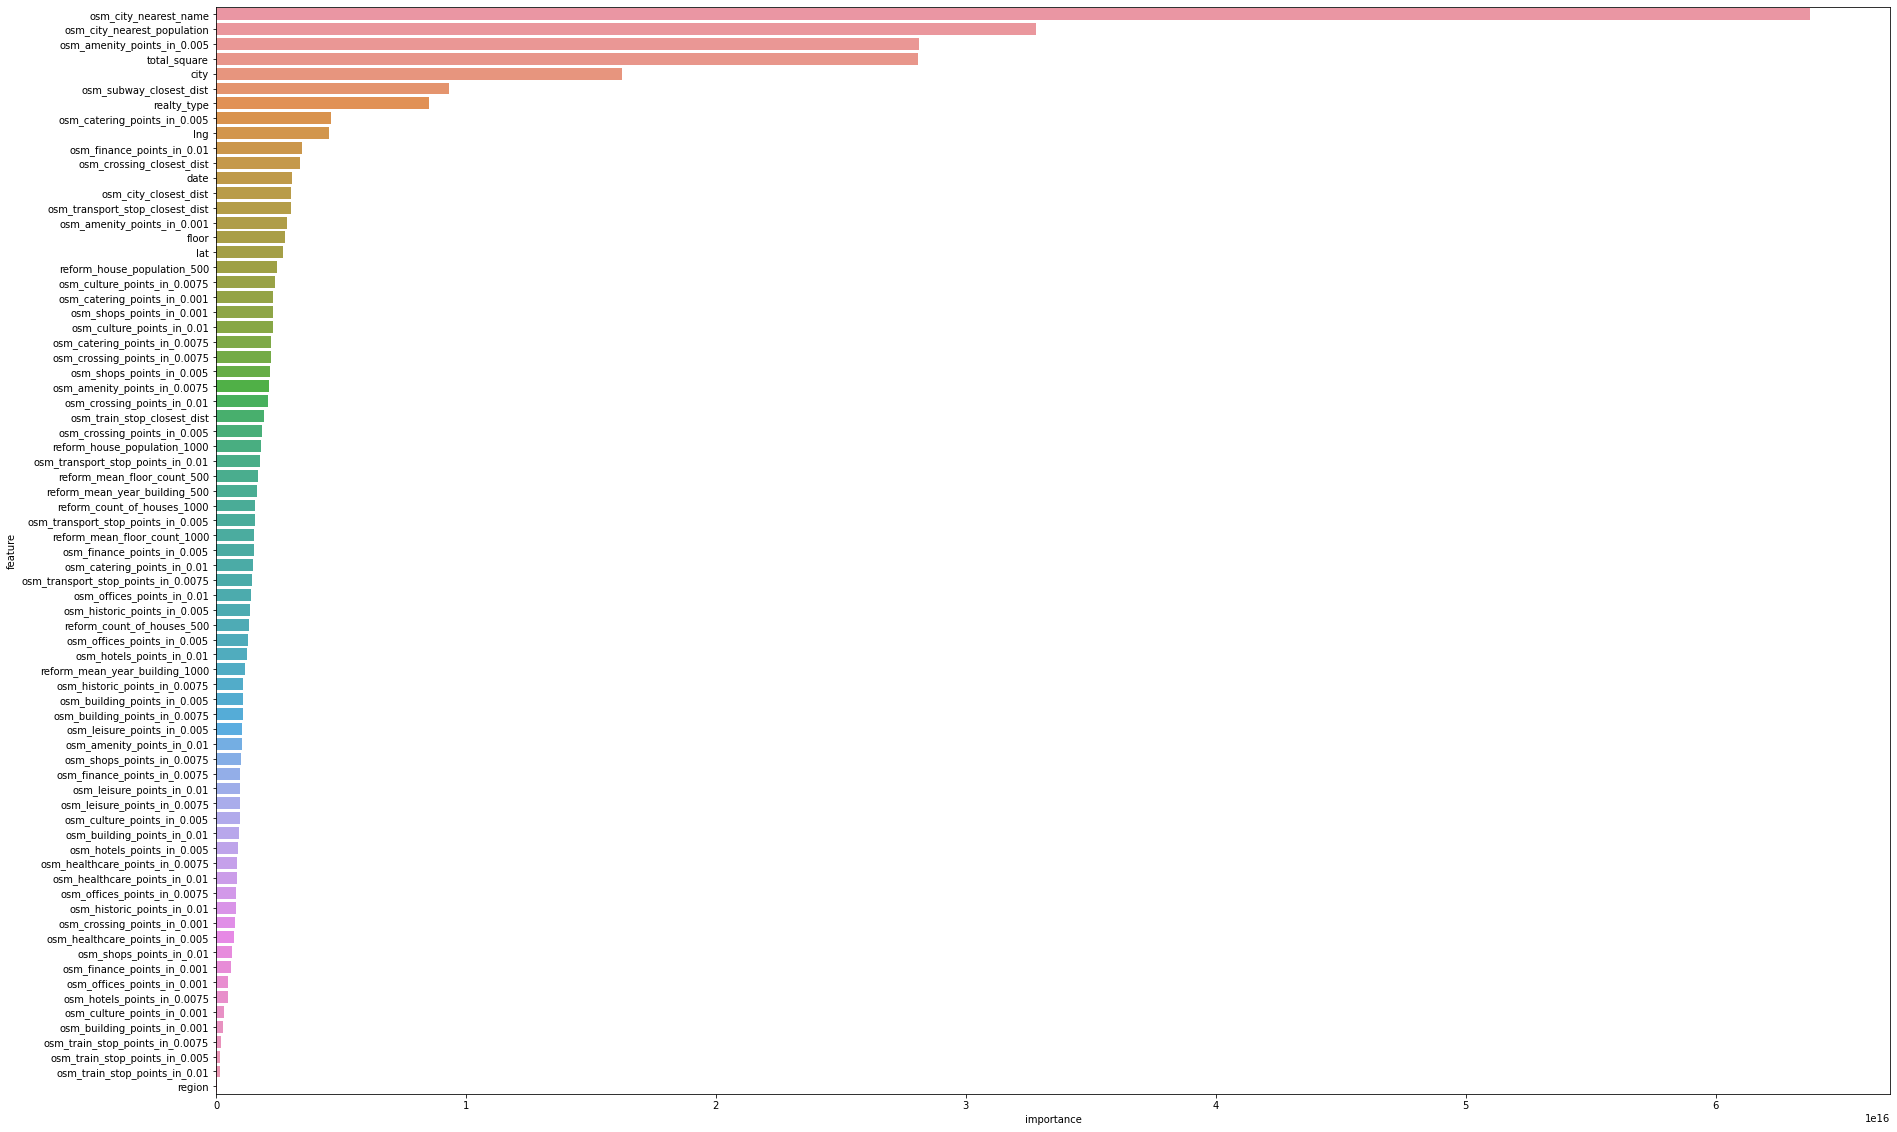

In [8]:
fig, ax = plt.subplots(figsize=(30, 20))
sns.barplot(data=feature_importance.sort_values(ascending=False).reset_index(name='importance').rename(columns={'index' : 'feature'}),
    x = "importance",
    y = "feature",
    orient = "h",
    ax = ax)
fig.savefig('research/plot/feature_importance.jpg')

In [13]:
# Predict val
test_df['per_square_meter_price'] = model.predict(test_df[NUM_FEATURES+CATEGORICAL_OHE_FEATURES+CATEGORICAL_STE_FEATURES])
# Save results
test_df[['id','per_square_meter_price']].to_csv(args['o_tst'], index=False)

# Predict train1
pd.Series(predictions_manual, index=pd.Index(train_df[train_df.price_type == PriceTypeEnum.MANUAL_PRICE]['id'], name='id'), name='per_square_meter_price').to_frame().to_csv(args['o_tr'])

In [12]:
predictions = pd.read_csv(args['ans'])

metrics = metrics_stat(test_df['per_square_meter_price'].values, predictions['per_square_meter_price'].values)
print(f'Metrics stat for validation data: {metrics}')

Metrics stat for validation data: {'mdape': 0.06409473950993083, 'rmse': 22095.45584633271, 'r2': 0.8477338494176158, 'raif_metric': 0.2755544235448334}
